<a href="https://colab.research.google.com/github/Vy4thewin/Python/blob/main/Data602_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 602 Final | NYC cleaniness via Rodent
## By Vyanna Hill

[Presentation](https://)

### Introduction 


Let's start our rodent analysis on NYC restaurants! As a refresher for the final project, I will look into the correlation of NYC restaurants' food grade score and their area's sightings with rodents. I like to see if the correlation of restaurants's overall food score affects the residental area's sighthings with the rodent popluation of NYC. 

The theory is restaurant's maintenance of their establishment may have a larger affect on the residental area sightings with rodents. A common factor of the attractions for rodents is the improper storage and disposial of food. Resturants handle large amounts of produce and must follow DOH's rules of food safety in order to product NYC residents health. So, open food scraps or uncovered garabage disposal can attract rodents and their droppings. 

Before we dive into our analysis, I have a few callouts of the project's limitations below. First, there is a assumption that this project is focus of restaurant's as the main source of overall upkeep of the zipcode. There was not a available DSNY dataset to cross check the current schedule sanitation cleaning and pickups based on the zipcodes, which also a major factor with the rodent population. Another limtation is limited data entries used in order to populate and run my analysis.

In [208]:
#loading all libraries used in the data analysis
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

#retrieve data sets for analysis. Best thing about json api is we can grab more data with the "?$limit", I choose 10,000 as the michelle dataset only had 6586 entries for New York City only an to buffer for any missing values
rodent_data=pd.read_json("https://data.cityofnewyork.us/resource/p937-wjvj.json?$limit=10000")
rest_data=pd.read_json("https://data.cityofnewyork.us/resource/43nn-pn8j.json?$limit=10000")

#we will use grpahs made from assignement 8 with one of our data sets (Michelle Map)

#### Data Wrangling

In order to analyze our datasets, we must clean the current data from any missing values or remove any invalid entries. Both data sets will drop any entries were the zipcode in not found as the analysis uses zipcode as the qualitative variable for the main statistical test used. For the specific data set, I will breakout any data subsititutions for invalid or NA values.


#### Rodent Data set


In [209]:
# Drop any rows where the zipcode is not found
rodent_data=rodent_data[rodent_data["zip_code"].notnull()]

#reducing our scope, let's see entries with valid rodents sightings. Dropping rows were the intial search saw no rodents will not count in our rodent map
alt_rodent=rodent_data[~((rodent_data.inspection_type=="Initial")& (rodent_data.result=="Passed"))]

#Keeping only relevant rows for our data set, dropping any unrelevant columns from our scope
alt_rodent= alt_rodent.drop(["job_ticket_or_work_order_id","job_id","job_progress","bbl","block","lot",":@computed_region_sbqj_enih",":@computed_region_92fq_4b7q",":@computed_region_f5dn_yrer",":@computed_region_yeji_bk3q",":@computed_region_efsh_h5xi"],axis=1)

#Let's also make a map version of the rodent data set and plot our results

#remove any entries w/o x an y corridnates so we can plot via geopandas
map_rodent=alt_rodent[(alt_rodent.x_coord.notnull())&(alt_rodent.y_coord.notnull())]

map_rodent=map_rodent[~((map_rodent.x_coord==0.0)&(map_rodent.y_coord==0.0))]

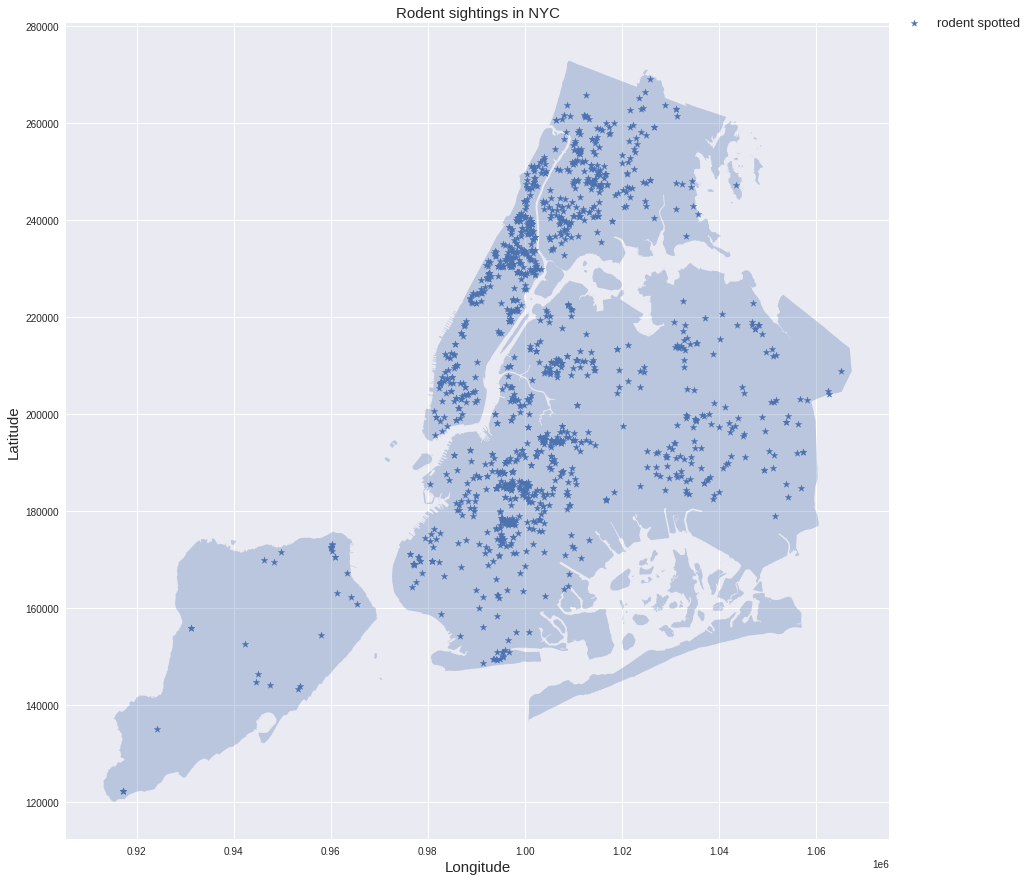

In [210]:
#First, create a geo data frame to convert the x/y corridinates into points
geo_rodents=gpd.GeoDataFrame(map_rodent,geometry=gpd.points_from_xy(map_rodent.x_coord,map_rodent.y_coord))

#load the NYC Map from geopandas w/ get_path for NYC bouroughs
nyc_map= gpd.read_file(gpd.datasets.get_path("nybb"))

#Now the base layer is set, let's set the axis be the base layer's dimensions and plot our points 
axis=nyc_map.plot(figsize=(15,15),alpha=0.3)
geo_rodents.plot(ax=axis,marker="*")


#add in lables for our axis and create a legend to identify the points on the map as locations
plt.style.use('seaborn-notebook')
plt.xlabel("Longitude",fontsize=15)
plt.ylabel("Latitude",fontsize=15)
plt.title("Rodent sightings in NYC",fontsize=15)
plt.legend(["rodent spotted"],bbox_to_anchor = (1 , 1),fontsize=13,loc="center left")


#### Food Inspection data set


Just for reference, the letter grade DOH uses is detailed in the data set [details](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j).
"
Grade associated with the inspection; • N = Not Yet Graded• A = Grade A• B = Grade B• C = Grade C• Z = Grade Pending• P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure"
"

In [211]:
# Drop any rows where the zipcode and the food grade is not found
rest_data=rest_data[(rest_data["zipcode"].notnull())&(rest_data["score"]).notnull()]
rest_data=rest_data[~(rest_data["zipcode"]==0.0)]

#For any null food grade scoring, fill in their score based on DOH scoring system
#0-13- A, 14-27-B, 28+ C, For businesses that were shut down, we will give it a F
for n in rest_data["score"]:
  if n < 13:
    rest_data["grade"].fillna("A",inplace=True)
  elif 14<=n<=17:
    rest_data["grade"].fillna("B",inplace=True)
  else:
    rest_data["grade"].fillna("c",inplace=True)

#Just overiding all the C's if the business was shutdown as its a automatic F
rest_data['grade'].mask(rest_data['action'] == 'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.',"F", inplace=True)

#now, we can drop any unrelevant rows found in this data set
alt_rest= rest_data.drop(["camis","phone","inspection_date","record_date","community_board","council_district","bin","bbl","nta","dba","cuisine_description","grade_date"],axis=1)



Text(0.5, 1.0, 'Restaurant letter grades across in NYC')

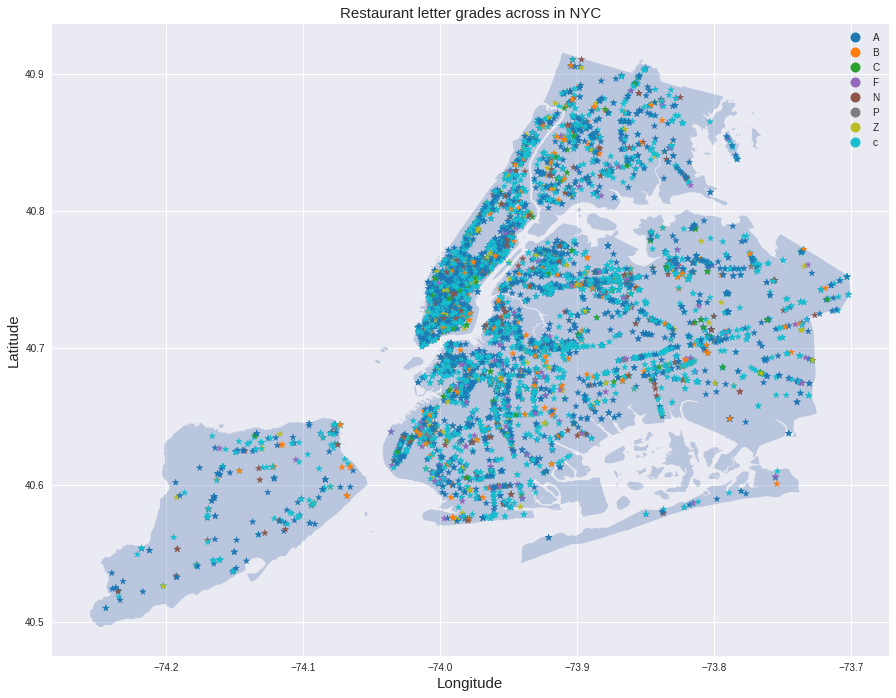

In [212]:
#Let's match our corridnates to our geo_rest by changing the preset map from feet to degrees
nyc_map=nyc_map.to_crs("EPSG:4326")

#reiterate steps from the previous map made above
geo_rest=gpd.GeoDataFrame(alt_rest,geometry=gpd.points_from_xy(alt_rest.longitude,alt_rest.latitude))
plt.style.use('seaborn')
axis=nyc_map.plot(figsize=(15,15),alpha=0.3)
geo_rest.plot(ax=axis,marker="*",column="grade",legend=True)
plt.xlabel("Longitude",fontsize=15)
plt.ylabel("Latitude",fontsize=15)
plt.title("Restaurant letter grades across in NYC",fontsize=15)



#### Findings from the Michelin star data set

From our introduction, we will use the michelin star analysis from  [assignment 8](https://github.com/Vy4thewin/Python/blob/main/Data602_A9.ipynb). For a recap, I analyzed the michelin star restaurants data for only NYC. The largest cluster on michelin restaurants were in lower manttahan seen in the graph below. 

We can use this cluster as a marker of "high income" residental area of manttahan, where people of high incomes will expect high food establishment standards with the price point of thier meals. I used this collection of zicodes to see if high scale food estabhlishment' residental areas see low rodent sightings [^1] : 10004, 10005, 10006, 10007, 10038, 10280, 10012, 10013, 10014.

[^1]:https://www1.nyc.gov/assets/doh/downloads/pdf/epi/Manhattan

In [213]:
#Create a list of lower manttahan zipcodes to see if there's a expection for michelin star food places
high_zip=[10004, 10005, 10006, 10007, 10038, 10280, 10012, 10013, 10014]

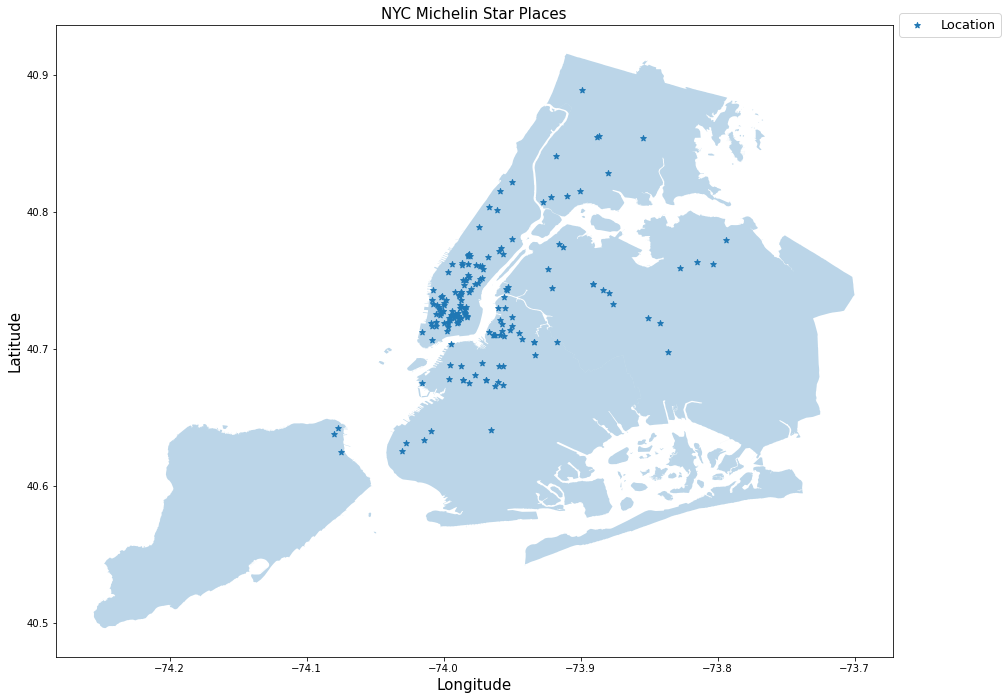

### Data Analysis

The initial reports for rodent activity account for ~98% of overall entries. Looking into the initial entries, only 28% confirmed rodent activity. This percentage is a little more promising that not all intial sightings count as a rodent place. 

<ipython-input-214-36c16d26ab80>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alt_rodent[rodent_data.inspection_type=="Initial"].shape[0]


Text(0.5, 1.0, 'Overview of rodent reports in NYC')

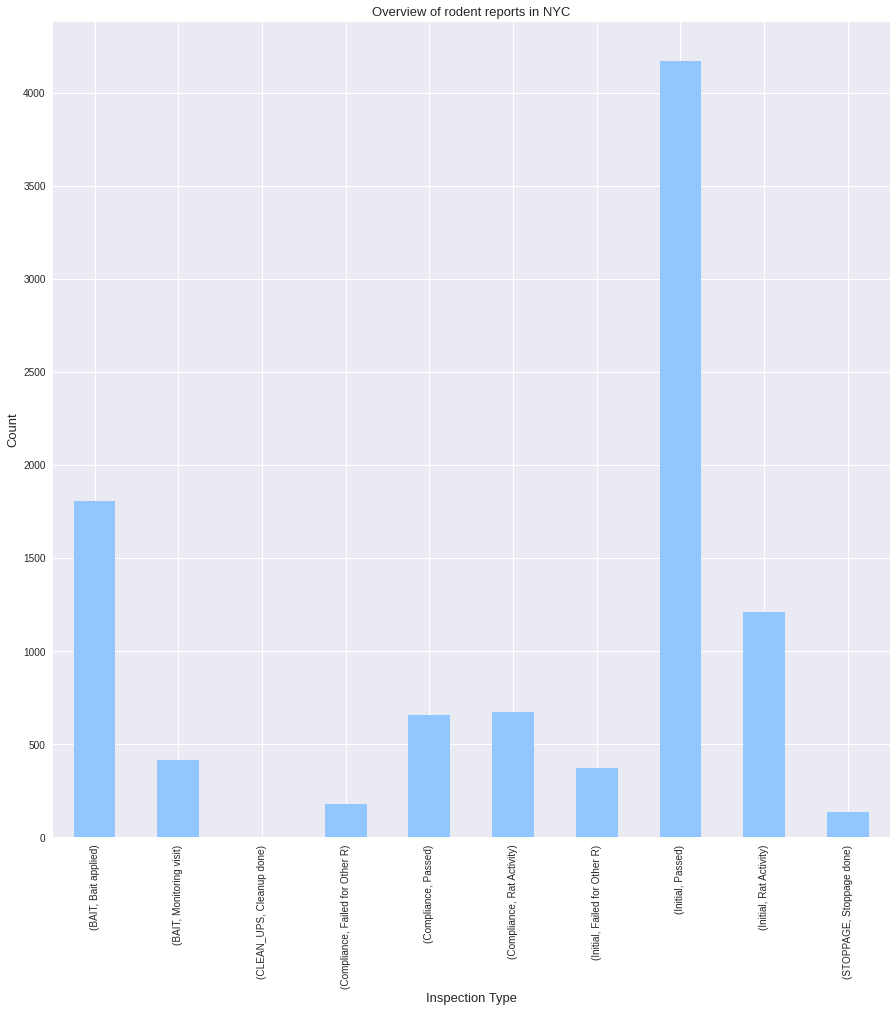

In [214]:
#find over initial reports| 4,402 reports seen are intital
rodent_data[rodent_data.inspection_type=="Initial"].shape[0]

#find the amount of inital reports which found no rodents| 3,168 did not find any creatures after investigation
rodent_data[((rodent_data.inspection_type=="Initial")& (rodent_data.result=="Passed"))].shape[0]

#find confirmed sightings of rodents| 1,234 saw confirmed activity
alt_rodent[rodent_data.inspection_type=="Initial"].shape[0]

#show these results below
plt.style.use('seaborn-pastel')
rodent_data.groupby(["inspection_type","result"]).size().plot(kind="bar",figsize=(15,15))
plt.xlabel("Inspection Type",fontsize=13)
plt.ylabel("Count",fontsize=13)
plt.title("Overview of rodent reports in NYC",fontsize=13)

The average food scores for the five boroughs are seen below with Staten Island with the lowest food grade score overall. Let's move to combine the two data sets to confirm if there is a statistical relationship between the letter grade the percentage of rodent activity in a particular zip code.

In [215]:
#find the average score of restaruant inspection by bourogh
alt_rest.groupby("boro")["score"].mean()


boro
0                29.000000
Bronx            20.481290
Brooklyn         22.834603
Manhattan        21.031841
Queens           22.036810
Staten Island    19.422311
Name: score, dtype: float64

#### Combininng both data sets

When the data sets were combined, there were a few zipcodes that did not report any confirmed rodent sightings. This means that those zip codes food scores can be based on the other reasons besides vermin in the restaurant. For now, we can subsitute any NAs in the combined data set with zeros.


In [216]:
#creating a seperate data set for our stat analysis
c_rodent= alt_rodent.drop(["inspection_type","boro_code","borough","inspection_date","approved_date","house_number","street_name","latitude","longitude","location","x_coord","y_coord"],axis=1)

#Let's groups all rodents sightings by zipcode 
c_rodent=c_rodent.groupby("zip_code")["result"].count().reset_index()

#For our analysis, lets find the zipcode's percentage of overall rating sightings in NYC
c_rodent["per_rat"]= c_rodent["result"]/4471

In [217]:
#for the restaurant data, find the area's average food score and its resulting 
c_rest=alt_rest.groupby("zipcode")["score"].mean().reset_index()

#create a function to determine the zip code's letter grade
def letter(row):
  if row["score"] < 13:
    return "A"
  elif 14<=row["score"]<=17 :
    return "B"
  else:
   return "C"

c_rest["grade"]=c_rest.apply(letter, axis=1)

c_rest

,zipcode,score,grade
0,10001,19.118056,C
1,10002,22.692308,C
2,10003,21.638614,C
3,10004,22.260870,C
4,10005,27.166667,C
...,...,...,...
190,11691,18.428571,C
191,11692,1.000000,A
192,11693,21.400000,C
193,11694,15.875000,B


Looking at our completed chart, we see the highest vermin counts by zipodes. For insight, the boroughs with the most sigthings are Brooklyn (Stuyvesant),Bronx (Fordham), Harlem. The majority of the top rodent sightings have a letter scores of C, which could mean a relationship between food score and rodent percentage. Let's find out if this assumption is statistically significant. 


In [218]:
# zipcode| average food score| Letter grade| percent_ratw|
#Now, let's do a left join of the Food grade and rodent popluation joining on the zip code
c_rodent.rename(columns={'zip_code':'zipcode','result':'Total incidents'}, inplace=True)
c_rest['zipcode']=c_rest['zipcode'].astype(float)
combo=c_rest.merge(c_rodent,on="zipcode",how="left")

#handling the amount of NAs, we will account these values as zeros
combo["per_rat"].fillna(0,inplace=True)
combo["Total incidents"].fillna(0,inplace=True)

#Let's see the top ten rodent sightings by zipcode
combo.nlargest(n=10,columns=['per_rat','zipcode'])



,zipcode,score,grade,Total incidents,per_rat
123,11221.0,24.297297,C,367.0,0.082085
118,11216.0,20.423077,C,335.0,0.074927
134,11233.0,20.205882,C,215.0,0.048088
77,10458.0,16.053333,B,167.0,0.037352
138,11237.0,19.405405,C,161.0,0.036010
108,11206.0,20.620000,C,161.0,0.036010
22,10025.0,21.482353,C,157.0,0.035115
76,10457.0,21.133333,C,152.0,0.033997
75,10456.0,19.500000,C,135.0,0.030195
85,10466.0,26.100000,C,133.0,0.029747


In [219]:
import scipy.stats as stats

#Group all the zipcodes' percent rodent population by its grade and use a anova one way test to find its p/f-value
grades=combo.groupby("grade").groups
grade_c=combo.per_rat[grades["C"]]
grade_b=combo.per_rat[grades["B"]]
grade_a=combo.per_rat[grades["A"]]

stats.f_oneway(grade_c,grade_b, grade_a)


F_onewayResult(statistic=3.93454249802202, pvalue=0.02115134680951376)

The anova test will show if the letter grade has a strong linear relationship with the rodent population percentage. The null hypothesis states is no statistical sigificance between the zipcodes' overall letter grade and its rodent sighting 

Looking at our statistics above, our F-statistic is ~3.86 and p-value of ~0.02. The p-value is lower than 0.05, which we can reject the null hypothesis.

### Conclusion

The relationship between the percentage of overall confirmed rodent sighting and the zip code overall letter grade is statiscally sigificant. It can be assumped that zipcodes with letter scores lower than a A have a higher probability of a rodent sighting in the area.  


## Abstract

The final project's objective was to evaluate the correlation between the rodent populations and the area's letter grade by the Department of Health and Mental Hygiene (DOHMH). If the correlation was correct, residents have an extra proof for community action.

 The statistical method used for analysis was the ANOVA test. The ANOVA test sought to find the correlation between Letter grade and its collection of rodent percentages. The null hypothesis was there was no relationship between the zipcode's rodent sighting percentage and its overall food letter. The alternative hypothesis supports the idea there was a relationship between the letter grade and its rodent percentage. 

The p-value for the one-way test was below the alpha threshold (p-value= 0.02 <=0.05). This p-value rejected the null hypothesis and supported the alternative of a relationship between the two variables.
The ANOVA analysis shows the relationship between rodent population percentage and the zip code's letter grade was statistically significant. There are a few limitations to the statistical assessment. First, there is no available data set to cross-check the sanitation schedule for garbage pick up. This affects the establishment's ability to maintain the disposal of scraps. Another limitation is the number of entries observed to process the analysis. There might be an influx of negative scores for one zip code at the time of collection.